Esta notebook contiene bloques de código útiles para realizar Q-learning en el entorno "Pendulum"

In [221]:
import numpy as np
from tqdm import tqdm
from pendulum_env_extended import PendulumEnvExtended
import random 
import matplotlib.pyplot as plt

In [222]:
env = PendulumEnvExtended(render_mode="rgb_array")

In [223]:
max_steps= env.max_steps
max_steps

1000

Discretización de los estados

In [224]:
x_space_partitions = 10
y_space_partitions = 10
vel_space_partitions = 100

In [225]:
x_space = np.linspace(-1, 1, x_space_partitions)
x_space

array([-1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 ,
       -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15,
       -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,
        0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,
        0.8 ,  0.85,  0.9 ,  0.95,  1.  ])

In [226]:
y_space = np.linspace(-1, 1, x_space_partitions)
y_space

array([-1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 ,
       -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15,
       -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,
        0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,
        0.8 ,  0.85,  0.9 ,  0.95,  1.  ])

In [227]:

vel_space = np.linspace(-8, 8, vel_space_partitions)
vel_space

array([-8.  , -7.68, -7.36, -7.04, -6.72, -6.4 , -6.08, -5.76, -5.44,
       -5.12, -4.8 , -4.48, -4.16, -3.84, -3.52, -3.2 , -2.88, -2.56,
       -2.24, -1.92, -1.6 , -1.28, -0.96, -0.64, -0.32,  0.  ,  0.32,
        0.64,  0.96,  1.28,  1.6 ,  1.92,  2.24,  2.56,  2.88,  3.2 ,
        3.52,  3.84,  4.16,  4.48,  4.8 ,  5.12,  5.44,  5.76,  6.08,
        6.4 ,  6.72,  7.04,  7.36,  7.68,  8.  ])

Obtener el estado a partir de la observación

In [228]:
def get_state(obs):
    x, y, vel = obs
    x_bin = np.digitize(x, x_space)
    y_bin = np.digitize(y, y_space)
    vel_bin = np.digitize(vel, vel_space)
    return x_bin, y_bin, vel_bin

In [229]:
state = get_state(np.array([-0.4, 0.2, 0.3]))
state

(12, 24, 26)

Discretización de las acciones

In [230]:
actions_partitions = 10

In [231]:
actions = list(np.linspace(-2, 2, actions_partitions))

[-2.0,
 -1.9,
 -1.8,
 -1.7,
 -1.6,
 -1.5,
 -1.4,
 -1.2999999999999998,
 -1.2,
 -1.1,
 -1.0,
 -0.8999999999999999,
 -0.7999999999999998,
 -0.7,
 -0.5999999999999999,
 -0.5,
 -0.3999999999999999,
 -0.2999999999999998,
 -0.19999999999999996,
 -0.09999999999999987,
 0.0,
 0.10000000000000009,
 0.20000000000000018,
 0.30000000000000027,
 0.40000000000000036,
 0.5,
 0.6000000000000001,
 0.7000000000000002,
 0.8000000000000003,
 0.9000000000000004,
 1.0,
 1.1,
 1.2000000000000002,
 1.3000000000000003,
 1.4000000000000004,
 1.5,
 1.6,
 1.7000000000000002,
 1.8000000000000003,
 1.9000000000000004,
 2.0]

In [232]:
def get_sample_action():
    return random.choice(actions)

Inicilización de la tabla Q

In [233]:
Q = np.zeros((len(x_space) + 1, len(y_space) + 1, len(vel_space) + 1, len(actions)))
Q

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

Obtención de la acción a partir de la tabla Q

In [234]:
def optimal_policy(state, Q):
    action = actions[np.argmax(Q[state])]
    return action

Epsilon-Greedy Policy

In [235]:
def epsilon_greedy_policy(state, Q, epsilon=0.1):
    explore = np.random.binomial(1, epsilon)
    if explore:
        action = get_sample_action()
    # exploit
    else:
        action = optimal_policy(state, Q)
        
    return action

Ejemplo de episodio 

In [236]:
obs,_ = env.reset()
done = False
total_reward = 0
state = get_state(obs)
while not done:
    # Acción del modelo
    action = epsilon_greedy_policy(state, Q, 0.5)
    
    # Indice de la accion en Q
    action_idx = actions.index(action)
    
    # Acción del ambiente
    real_action = np.array([action_idx])
     
    obs, reward, done, _, _ = env.step(real_action)
    next_state = get_state(obs)
    
   # Usar action_idx para actualizar Q
   
    total_reward += reward
    print('->', state, action, reward, obs, done)
print('total_reward', total_reward)

[ 0.99402153 -0.1091841   0.30917716]
-> (40, 18, 26) -0.7999999999999998 -0.025527895044471904 [ 0.9965544  -0.08294236  0.5272891 ] False
-> (40, 18, 26) -1.6 -0.038698646487816304 [ 0.9989974  -0.04476867  0.7650823 ] False
-> (40, 18, 26) -2.0 -0.060540668967385546 [ 0.9999663  -0.00820826  0.7315058 ] False
-> (40, 18, 26) -0.5999999999999999 -0.05757745197183449 [0.9990731  0.04304583 1.0253496 ] False
-> (40, 18, 26) 1.7000000000000002 -0.11098827263016414 [0.9938524 0.1107134 1.357634 ] False
-> (40, 18, 26) -2.0 -0.19662487257959876 [0.9833069  0.18195501 1.4406691 ] False
-> (40, 18, 26) -0.09999999999999987 -0.24503231539396242 [0.96192634 0.27330872 1.8771353 ] False
-> (40, 18, 26) -1.0 -0.43299911911220257 [0.9226356  0.38567278 2.3821168 ] False
-> (40, 18, 26) -2.0 -0.7242140828373038 [0.86305696 0.50510657 2.6713715 ] False
-> (40, 18, 26) -2.0 -0.9939985537615279 [0.77630377 0.630359   3.0502014 ] False
-> (40, 18, 26) -1.2999999999999998 -1.399518008166356 [0.6424049

In [237]:
max_steps = env.max_steps

In [238]:
epsilon = 0.99

In [239]:
alpha = 0.05
alpha

0.05

In [240]:
gamma = 0.9
gamma

0.9

In [241]:
episodes=8000

In [242]:
rewards=[]
steps=[]

In [243]:
i=0
for i in tqdm(range(episodes)):
    obs,_ = env.reset()
    done = False
    total_reward = 0    
    total_steps = 0 
    state = get_state(obs)
    while not done:        
        action = epsilon_greedy_policy(state, Q, epsilon)
        action_idx = actions.index(action)    
        real_action = np.array([action_idx])

        obs, reward, done, _, _ = env.step(real_action)

        next_state = get_state(obs)

        total_steps += 1 
        total_reward += reward

        value = Q[state][action_idx] + alpha * (reward + (gamma* (np.max(Q[next_state]))) - Q[state][action_idx] )
        Q[state][action_idx] = value

        state = next_state
    i+=1
    if (i % 5== 0) and (epsilon > 0.01):  
        epsilon *= 0.99
    rewards.append(total_reward)
    steps.append(total_steps)

100%|██████████| 8000/8000 [06:13<00:00, 21.43it/s]


In [244]:
epsilon

0.009920974201040588

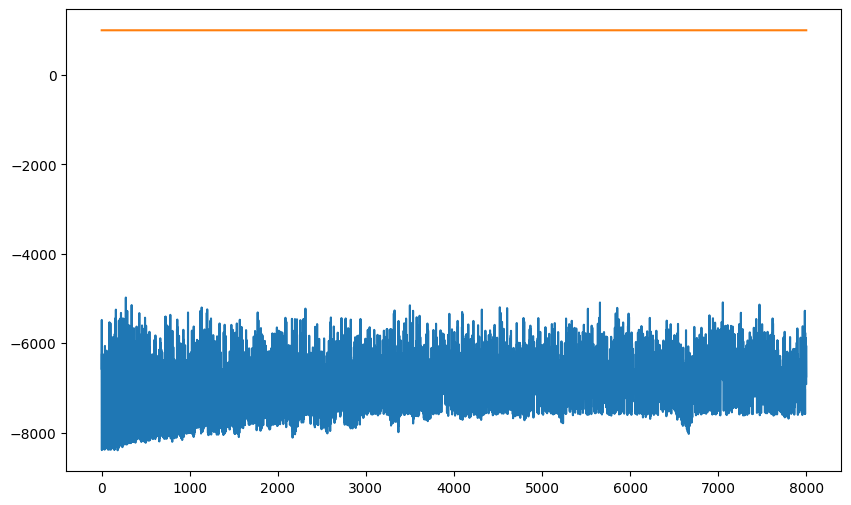

In [245]:
plt.figure(figsize=(10, 6))
plt.plot(rewards)
plt.plot(steps)

plt.show()

In [246]:
average_steps = np.mean(steps)
print("average steps: ", average_steps)
average_rewards = np.mean(rewards)
print("Average rewards: ", average_rewards)

average steps:  1000.0
Average rewards:  -7038.13157389654


In [247]:
Q

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

### Render

In [248]:
obs,_ = env.reset()
print(obs)
done = False
total_reward = 0
state = get_state(obs)
while not done:
    action = epsilon_greedy_policy(state, Q, 0.9)
    action_idx = actions.index(action)
    real_action = np.array([action_idx])
     
    obs, reward, done, _, _ = env.step(real_action)
    next_state = get_state(obs)
   
    total_reward += reward
    print('->', state, action, reward, obs, done)
    env.render()
    
print('total_reward', total_reward)

[ 0.39684662 -0.91788495  0.9747579 ]
-> (28, 2, 29) 1.8000000000000003 -1.450927369652165 [ 0.42358205 -0.90585774  0.5863442 ] False
-> (28, 2, 29) -1.8 -1.32297625510698 [ 0.43293262 -0.9014263   0.20695089] False
-> (28, 2, 29) -0.7999999999999998 -1.2695304215353114 [ 0.42529482 -0.90505487 -0.16911882] False
-> (28, 2, 29) 0.9000000000000004 -1.287172112119142 [ 0.4003439  -0.91636497 -0.54791   ] False
-> (28, 2, 29) -0.5999999999999999 -1.3770795348950804 [ 0.35707346 -0.9340763  -0.9351837 ] False
-> (28, 2, 29) 1.8000000000000003 -1.5450811138935814 [ 0.29393956 -0.955824   -1.3357409 ] False
-> (28, 2, 29) -1.1 -1.801550550301357 [ 0.20915955 -0.97788155 -1.7526089 ] False
-> (28, 2, 29) 1.4000000000000004 -2.1609838780374004 [ 0.10124066 -0.99486196 -2.1860201 ] False
-> (28, 2, 29) -2.0 -2.6369515789189992 [-0.04517853 -0.9989789  -2.9321666 ] False
-> (28, 2, 29) -0.7 -3.4751845242005333 [-0.21262826 -0.97713315 -3.3814008 ] False
-> (28, 2, 29) -0.09999999999999987 -4.33